# Computer Vision - Convolutional Neural Network (CNN)

## Summary:
**Dataset:** CIFAR100 32x32 pixel coloured images with corresponding content classification number  
**Model:** Classifies the content of an image using a CNN     
**Particulars:** CNN based on the AlexNet architecture with appropriate modifications  

## Table of Contents:
* Section 1 - Exploring Data and Pre-processing
* Section 2 - Generating Model and Training
* Section 3 - Final Model and Results

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import datasets, models, layers

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Importing CIFAR100 data, which is a lower resolution and smaller dataset compared to ImageNet
# Dataset contains images belonging to 10 categories/classes with the accompanying class number

(X_train_full, y_train_full), (X_test, y_test) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 14s 0us/step


# Section 1 - Exploring Data and Pre-processing

In [3]:
# Checking the number of training and test data points

X_train_full.shape
print('\n')
X_test.shape
print('\n')
X_train_full.min(), X_train_full.max()

(50000, 32, 32, 3)

(10000, 32, 32, 3)

(0, 255)

In [4]:
# Details of the dataset values

df = pd.DataFrame(y_train_full)
df.describe()
df.info()

df.head()
print('\n')
df.describe()
print('\n')
df.info()

,0
count,50000.00000
mean,4.50000
std,2.87231
min,0.00000
25%,2.00000
50%,4.50000
75%,7.00000
max,9.00000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       50000 non-null  uint8
dtypes: uint8(1)
memory usage: 49.0 KB


,0
0,6
1,9
2,9
3,4
4,1


,0
count,50000.00000
mean,4.50000
std,2.87231
min,0.00000
25%,2.00000
50%,4.50000
75%,7.00000
max,9.00000




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       50000 non-null  uint8
dtypes: uint8(1)
memory usage: 49.0 KB


In [5]:
# Checking if dataset is balanced

df.value_counts()
df_test = pd.DataFrame(y_test)
df_test.value_counts()

0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
dtype: int64

0    1000
1    1000
2    1000
3    1000
4    1000
5    1000
6    1000
7    1000
8    1000
9    1000
dtype: int64

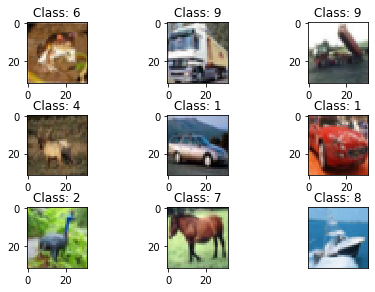

In [6]:
# Displaying some of the 32x32 pixel images contained in the dataset

fig, ax = plt.subplots(3, 3)

counter=0
fig.tight_layout()

for i in range(3):
  for j in range(3):
    _ = ax[i,j].imshow(X_train_full[counter], interpolation='none')
    _ = ax[i,j].set_title('Class: {}'.format(y_train_full[counter][0]))
    _ = plt.xticks([])
    _ = plt.yticks([])
    counter+=1

In [7]:
# Data pre-processing: min max scaling

min = X_train_full.min()
max = X_train_full.max()

min,max

X_train_full = X_train_full/(max-min)
X_test = X_test/(max-min)

(0, 255)

# Section 2 - Generating Model and Training

In [8]:
## The fllowing CNN is based on the AlexNet architecture. Deviations from this are outlined and explained in the comments which follow.

## AlexNet is designed for 227x227 bit images vs. 32x32 here -> scaling factor will be used: 32/227 ≈ 1/7

## Kernel sizes: All dimensions have been reduced to (2,2).
 # AlexNet kernel size are <= (11,11), therefore they were reduced for this model using the scaling factor of 1/7.

## Strides: All strides have been reduced to (1,1).
 # AlexNet uses strides of <= 4, therefore they were reduced for this model using the scaling factor of 1/7.

## Dropouts: Dropout has been added after each layer to reduce overfitting due to the higher complexity of AlexNet
 # The AlexNet model is made for 1,000 different classes, compared to only 10 classes here.

## Scaling factors: Scaling factors used on two layers in order to further reduce model complexity and reduce overfitting
 # Scaling factor of 1/4 used on the number of filters of Convolutional Hidden Layer 4.
 # Scaling factor of 1/2 used on the flattened Fully Connected Input Layer.

## MaxPooling: MaxPooling removed from the final Convolution Layer.
 # The image resolutions used in this model are already 1/7th of those used in AlexNet. The final Tensor dimensions are small enough and the final MaxPooling reduces it too much.

def Image_Classifier_Model(X_train, y_train, epoch_number=60, valid_split=0.2):
  K.clear_session()
  tf.random.set_seed(0)
  random.seed(0)

  #Convolutional Input Layer
  input = layers.Input(shape=X_train_full.shape[1:])

  # Convolutional Hidden Layer 1 + MaxPooling 1
  y = layers.Conv2D(filters=round(96), kernel_size=(2,2), strides=(1,1), padding="same", activation="relu")(input)
  y = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same")(y)
  y = layers.BatchNormalization()(y)
  y = layers.Dropout(0.2)(y)

  #Convolutional Hidden Layer 2 + MaxPooling 2
  y = layers.Conv2D(filters=round(256), kernel_size=(2,2), strides=(1,1), padding="same", activation="relu")(y)
  y = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same")(y)
  y = layers.BatchNormalization()(y)
  y = layers.Dropout(0.2)(y)

  #Convolutional Hidden Layers 3, 4, 5
  y = layers.Conv2D(filters=round(384), kernel_size=(2,2), strides=(1,1), padding="same", activation="relu")(y)
  y = layers.BatchNormalization()(y)
  y = layers.Dropout(0.5)(y)

  y = layers.Conv2D(filters=round(384), kernel_size=(2,2), strides=(1,1), padding="same", activation="relu")(y)
  y = layers.BatchNormalization()(y)
  y = layers.Dropout(0.5)(y)

  y = layers.Conv2D(filters=round(256/4), kernel_size=(2,2), strides=(1,1), padding="same", activation="relu")(y)
  y = layers.BatchNormalization()(y)
  #y = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding="same")(y)


  #Fully Connected Input Layer
  # AlexNet flattened layer goes from 9,216 nodes to 4,096, similar reduction ratio maintained here.
  y = layers.Flatten()(y)
  nodes_no = round((4096/9216)*(1/2)*y.get_shape().as_list()[1])
  y = layers.BatchNormalization()(y)
  y = layers.Dropout(0.5)(y)

  y = layers.Dense(nodes_no, activation="relu", kernel_initializer='glorot_uniform')(y)
  y = layers.BatchNormalization()(y)
  y = layers.Dropout(0.5)(y)

  #Fully Connected Hidden Layer 1
  y = layers.Dense(nodes_no, activation="relu", kernel_initializer='glorot_uniform')(y)
  y = layers.BatchNormalization()(y)
  y = layers.Dropout(0.5)(y)

  #Fully Connected Hidden Layer 2 (Softmax output)
  # AlexNet has a softmax of 1000, only 10 needed here
  output = layers.Dense(10, activation='softmax')(y)


  model = models.Model(input, output)

  model.compile(loss=keras.losses.sparse_categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(0.001),
                    metrics=[keras.metrics.sparse_categorical_accuracy])
  
  h = model.fit(X_train, y_train, epochs=epoch_number, batch_size=32, validation_split=valid_split)

  return model, h

model, h = Image_Classifier_Model(X_train_full, y_train_full)
model.summary()

Epoch 1/60
1250/1250 [==============================] - 37s 17ms/step - loss: 1.9776 - sparse_categorical_accuracy: 0.3612 - val_loss: 1.4689 - val_sparse_categorical_accuracy: 0.4771
Epoch 2/60
1250/1250 [==============================] - 21s 17ms/step - loss: 1.4048 - sparse_categorical_accuracy: 0.5017 - val_loss: 1.2913 - val_sparse_categorical_accuracy: 0.5526
Epoch 3/60
1250/1250 [==============================] - 21s 16ms/step - loss: 1.2325 - sparse_categorical_accuracy: 0.5664 - val_loss: 1.0368 - val_sparse_categorical_accuracy: 0.6232
Epoch 4/60
1250/1250 [==============================] - 22s 18ms/step - loss: 1.1114 - sparse_categorical_accuracy: 0.6081 - val_loss: 1.2063 - val_sparse_categorical_accuracy: 0.5858
Epoch 5/60
1250/1250 [==============================] - 21s 17ms/step - loss: 1.0210 - sparse_categorical_accuracy: 0.6400 - val_loss: 0.9522 - val_sparse_categorical_accuracy: 0.6691
Epoch 6/60
1250/1250 [==============================] - 21s 16ms/step - loss: 0.

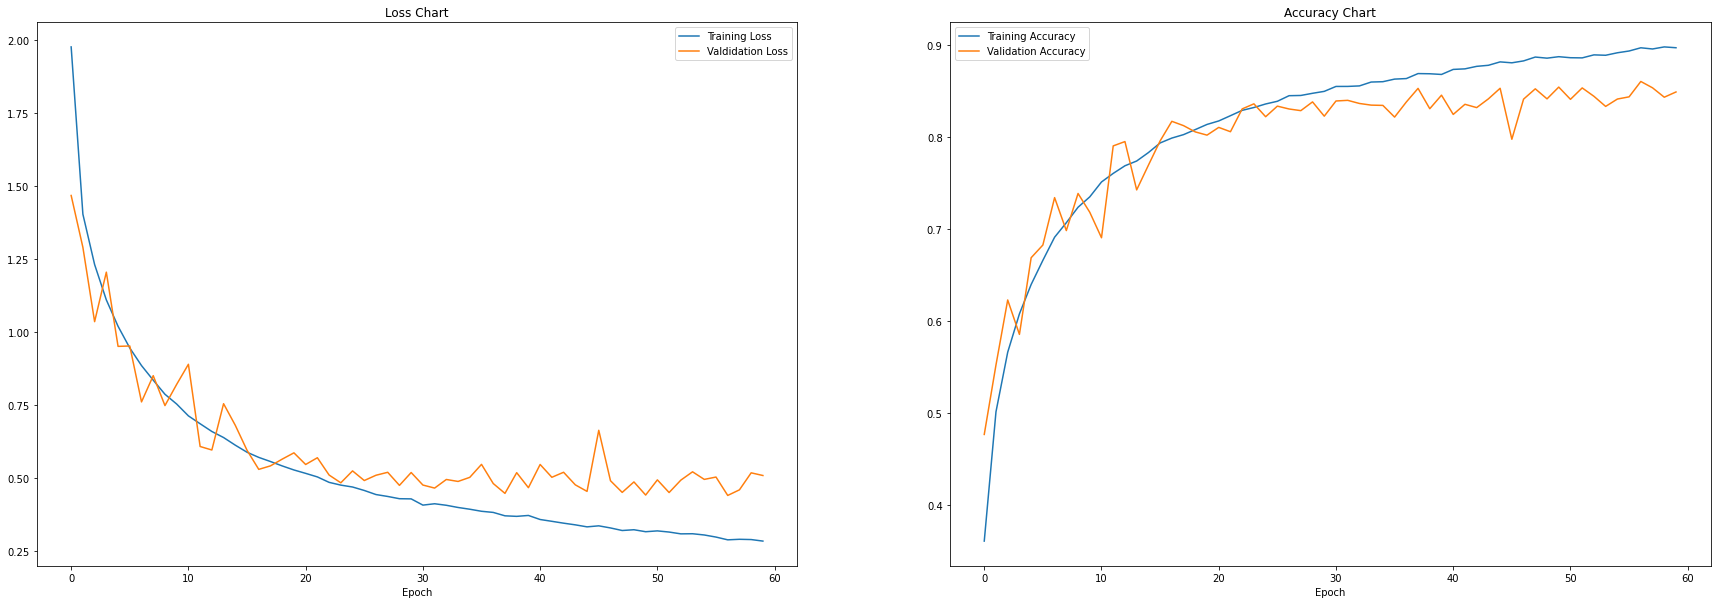

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))

_ = ax[0].plot(h.history['loss'], label = 'Training Loss')
_ = ax[0].plot(h.history['val_loss'], label = 'Valdidation Loss')
_ = ax[0].set_xlabel('Epoch')
_ = ax[0].set_title('Loss Chart')
_ = ax[0].legend()

_ = ax[1].plot(h.history['sparse_categorical_accuracy'], label = 'Training Accuracy')
_ = ax[1].plot(h.history['val_sparse_categorical_accuracy'], label = 'Validation Accuracy')
_ = ax[1].set_xlabel('Epoch')
_ = ax[1].set_title('Accuracy Chart')
_ = ax[1].legend()
    
plt.show()

# Section 3 - Final Model and Results

In [10]:
# Training the final model on the entire training dataset (i.e. no validation split) up to the optimum epoch number

val_losses = np.array(h.history['val_loss'])
epoch_number = np.argmin(val_losses) + 1

print('Optimum epoch runs:', epoch_number)

final_model, h_final = Image_Classifier_Model(X_train_full, y_train_full, epoch_number=epoch_number, valid_split=0)

Optimum epoch runs: 57
Epoch 1/57
1563/1563 [==============================] - 31s 16ms/step - loss: 1.8633 - sparse_categorical_accuracy: 0.3901
Epoch 2/57
1563/1563 [==============================] - 25s 16ms/step - loss: 1.3224 - sparse_categorical_accuracy: 0.5313
Epoch 3/57
1563/1563 [==============================] - 25s 16ms/step - loss: 1.1459 - sparse_categorical_accuracy: 0.5967
Epoch 4/57
1563/1563 [==============================] - 25s 16ms/step - loss: 1.0243 - sparse_categorical_accuracy: 0.6390
Epoch 5/57
1563/1563 [==============================] - 25s 16ms/step - loss: 0.9422 - sparse_categorical_accuracy: 0.6682
Epoch 6/57
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8728 - sparse_categorical_accuracy: 0.6950
Epoch 7/57
1563/1563 [==============================] - 25s 16ms/step - loss: 0.8135 - sparse_categorical_accuracy: 0.7170
Epoch 8/57
1563/1563 [==============================] - 25s 16ms/step - loss: 0.7654 - sparse_categorical_accuracy: 

In [11]:
test_loss, test_accuracy = final_model.evaluate(X_test, y_test)

print('\n')
print('Test Loss: %s       |   Test Accuracy: %s' % (round(test_loss, 4), round(test_accuracy, 4)))

313/313 [==============================] - 2s 6ms/step - loss: 0.4517 - sparse_categorical_accuracy: 0.8584


Test Loss: 0.4517       |   Test Accuracy: 0.8584
